# NOTEBOOK 4: ANÁLISIS AVANZADO (EXPERIMENTO 1)

Este notebook realiza un análisis exhaustivo de los modelos entrenados, cumpliendo con los requisitos del **Experimento 1: Comparación de Arquitecturas**.

## Objetivos
1.  **Comparativa Multidimensional**: Evaluar no solo Accuracy, sino también Precision, Recall, F1-Score y Latencia.
2.  **Análisis de Errores**: Visualizar matrices de confusión para entender dónde fallan los modelos.
3.  **Eficiencia**: Medir el tiempo de inferencia (rapidez en predicción) para aplicaciones en tiempo real.
4.  **Trade-off**: Identificar el mejor equilibrio entre rendimiento y costo computacional.

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from math import pi

# Configuración
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "data_processed"
MODELS_DIR = "models"
HIST_FILE = f"{MODELS_DIR}/histories.pkl"

print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


In [8]:
# =============================================================================
# 1. DEFINICIÓN DE CLASES (Necesario para cargar modelos)
# =============================================================================
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output, mask):
        scores = self.attn(rnn_output).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(rnn_output * attn_weights.unsqueeze(-1), dim=1)
        return context

class RecurrentClassifier(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, out_dim, n_layers, dropout, pad_idx, bidirectional=False, use_attention=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.model_type = model_type
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if model_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        
        self.rnn_out_dim = hidden_dim * (2 if bidirectional else 1)
        
        if use_attention:
            self.attention = AttentionPooling(self.rnn_out_dim)
        else:
            self.attention = None
            
        self.fc = nn.Linear(self.rnn_out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, x, lengths=None):
        mask = (x != self.pad_idx).float()
        emb = self.embedding(x)
        
        if self.model_type == 'lstm':
            rnn_out, (h_n, c_n) = self.rnn(emb)
        else:
            rnn_out, h_n = self.rnn(emb)
            
        if self.use_attention:
            context = self.attention(rnn_out, mask)
        else:
            if self.bidirectional:
                h_last = h_n.view(self.n_layers, 2, x.size(0), self.hidden_dim)[-1]
                context = torch.cat([h_last[0], h_last[1]], dim=1)
            else:
                context = h_n[-1]
                
        logits = self.fc(self.dropout(context))
        return logits

In [9]:
# =============================================================================
# 2. CARGA DE DATOS DE VALIDACIÓN
# =============================================================================
print("Cargando datos y vocabulario...")
vocab = pickle.load(open(f"{DATA_DIR}/vocab.pkl", "rb"))
val_df = pd.read_csv(f"{DATA_DIR}/val.csv")
PAD_IDX = vocab["<PAD>"]
UNK_IDX = vocab["<UNK>"]
MAX_LEN = 40

def encode_text(text, vocab):
    tokens = str(text).lower().split()
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

class FinancialTweetsDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["text"]
        label = int(self.df.iloc[idx]["label"])
        encoded = encode_text(text, self.vocab)
        return encoded, label

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = min(MAX_LEN, max(lengths))
    padded = []
    for seq in texts:
        seq = seq[:max_len]
        if len(seq) < max_len:
            seq = torch.cat([seq, torch.tensor([PAD_IDX] * (max_len - len(seq)))])
        padded.append(seq)
    return torch.stack(padded), torch.tensor(labels, dtype=torch.long), torch.tensor([min(l, max_len) for l in lengths])

val_ds = FinancialTweetsDataset(val_df, vocab)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)
print("Datos listos.")

Cargando datos y vocabulario...
Datos listos.


In [10]:
# =============================================================================
# 3. EVALUACIÓN DETALLADA
# =============================================================================
def evaluate_model_detailed(model_name, model_path):
    if not os.path.exists(model_path):
        print(f"Modelo {model_name} no encontrado.")
        return None

    # Cargar checkpoint
    checkpoint = torch.load(model_path, map_location=DEVICE)
    config = checkpoint['config']
    
    # Instanciar modelo
    model = RecurrentClassifier(
        model_type=config['model_type'],
        vocab_size=config['vocab_size'],
        embed_dim=config['embed_dim'],
        hidden_dim=config['hidden_dim'],
        out_dim=3,
        n_layers=config['n_layers'],
        dropout=config['dropout'],
        pad_idx=config['pad_idx'],
        bidirectional=config['bidirectional'],
        use_attention=config['use_attention']
    ).to(DEVICE)
    
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Medir latencia (Inferencia)
    start_time = time.time()
    with torch.no_grad():
        for xb, yb, lengths in val_loader:
            xb, yb, lengths = xb.to(DEVICE), yb.to(DEVICE), lengths.to(DEVICE)
            logits = model(xb, lengths)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    end_time = time.time()
    
    inference_time_ms = ((end_time - start_time) / len(val_ds)) * 1000 # ms por tweet
    
    # Métricas
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    prec_macro = precision_score(all_labels, all_preds, average='macro')
    rec_macro = recall_score(all_labels, all_preds, average='macro')
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'F1 (Macro)': f1_macro,
        'Precision': prec_macro,
        'Recall': rec_macro,
        'Inference (ms/tweet)': inference_time_ms,
        'preds': all_preds,
        'labels': all_labels
    }

results = []
configs = [
    'lstm_base', 'lstm_attn', 'gru_base', 'gru_attn', 'lstm_bi', 'lstm_bi_attn'
]

# Cargar historial de tiempos de entrenamiento
if os.path.exists(HIST_FILE):
    with open(HIST_FILE, "rb") as f:
        histories = pickle.load(f)
else:
    histories = {}

print("Evaluando modelos...")
for name in configs:
    res = evaluate_model_detailed(name, f"{MODELS_DIR}/{name}_best_model.pth")
    if res:
        # Añadir tiempo de entrenamiento del historial
        train_time = histories.get(name, {}).get('total_time', 0)
        res['Training Time (s)'] = train_time
        results.append(res)

df_results = pd.DataFrame(results).set_index('Model')
df_results = df_results[['Accuracy', 'F1 (Macro)', 'Precision', 'Recall', 'Training Time (s)', 'Inference (ms/tweet)']]
df_results = df_results.sort_values(by='F1 (Macro)', ascending=False)

print("\n=== LEADERBOARD (Ordenado por F1-Score) ===")
display(df_results.style.background_gradient(cmap='Greens', subset=['Accuracy', 'F1 (Macro)']))

Evaluando modelos...


C:\Users\andsa\AppData\Local\Temp\ipykernel_8132\1272428422.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)
C:\


=== LEADERBOARD (Ordenado por F1-Score) ===


C:\Users\andsa\AppData\Local\Temp\ipykernel_8132\1272428422.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


,Accuracy,F1 (Macro),Precision,Recall,Training Time (s),Inference (ms/tweet)
Model,,,,,,
lstm_bi,0.774126,0.658865,0.729301,0.627894,22.915302,0.101383
lstm_bi_attn,0.766434,0.647349,0.727598,0.612082,23.486363,0.103455
lstm_attn,0.753846,0.636233,0.690229,0.608394,17.995669,0.096456
gru_base,0.757343,0.624142,0.700726,0.590924,17.616622,0.076230
gru_attn,0.749650,0.620424,0.702271,0.593255,17.863293,0.079124
lstm_base,0.748951,0.594327,0.712726,0.560694,17.650448,0.140364


Matriz de Confusión: MEJOR MODELO (lstm_bi)


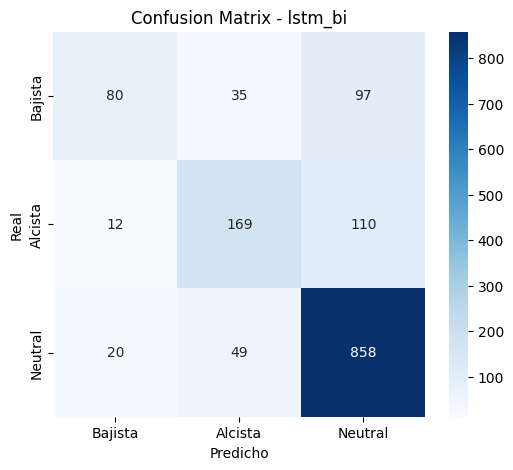

Matriz de Confusión: PEOR MODELO (lstm_base)


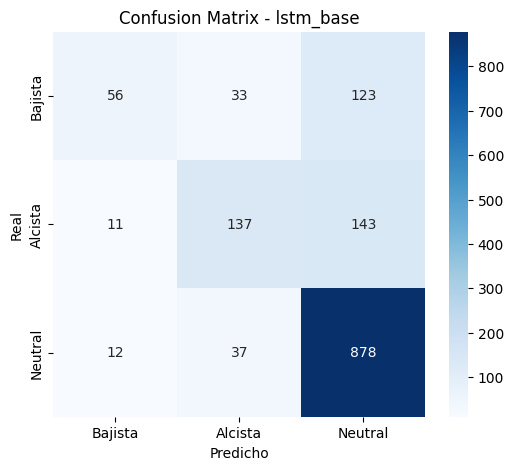

In [11]:
# =============================================================================
# 4. MATRICES DE CONFUSIÓN
# =============================================================================
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bajista', 'Alcista', 'Neutral'], yticklabels=['Bajista', 'Alcista', 'Neutral'])
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

# Mostrar matriz del mejor y peor modelo
best_model = df_results.index[0]
worst_model = df_results.index[-1]

best_res = next(r for r in results if r['Model'] == best_model)
worst_res = next(r for r in results if r['Model'] == worst_model)

print(f"Matriz de Confusión: MEJOR MODELO ({best_model})")
plot_confusion_matrix(best_res['labels'], best_res['preds'], f"Confusion Matrix - {best_model}")

print(f"Matriz de Confusión: PEOR MODELO ({worst_model})")
plot_confusion_matrix(worst_res['labels'], worst_res['preds'], f"Confusion Matrix - {worst_model}")

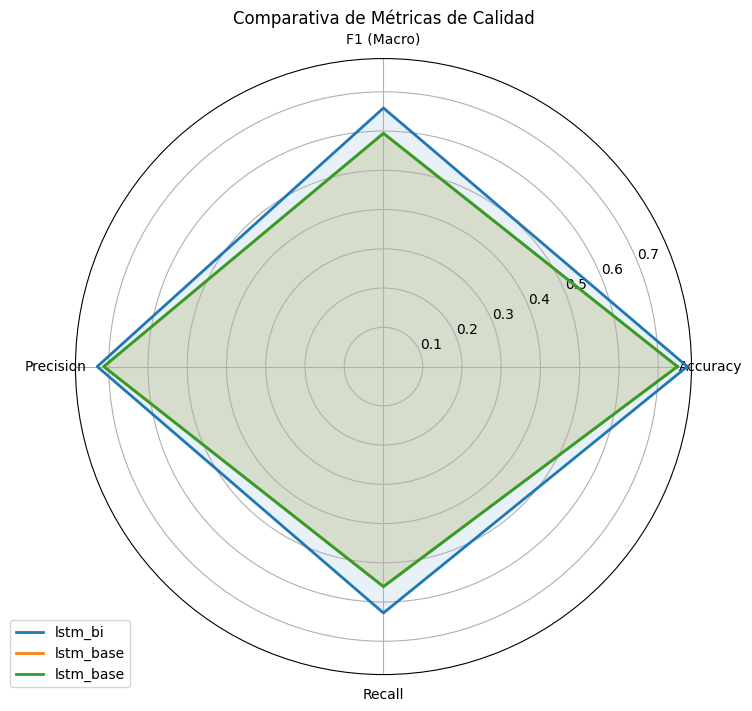

In [12]:
# =============================================================================
# 5. GRÁFICO DE RADAR (Comparativa Multidimensional)
# =============================================================================
def make_radar_chart(df, models_to_plot):
    # Normalizar datos para el gráfico (0-1)
    categories = ['Accuracy', 'F1 (Macro)', 'Precision', 'Recall']
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1], categories)
    
    for model in models_to_plot:
        values = df.loc[model, categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    plt.title("Comparativa de Métricas de Calidad")
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

make_radar_chart(df_results, [best_model, worst_model, 'lstm_base'])

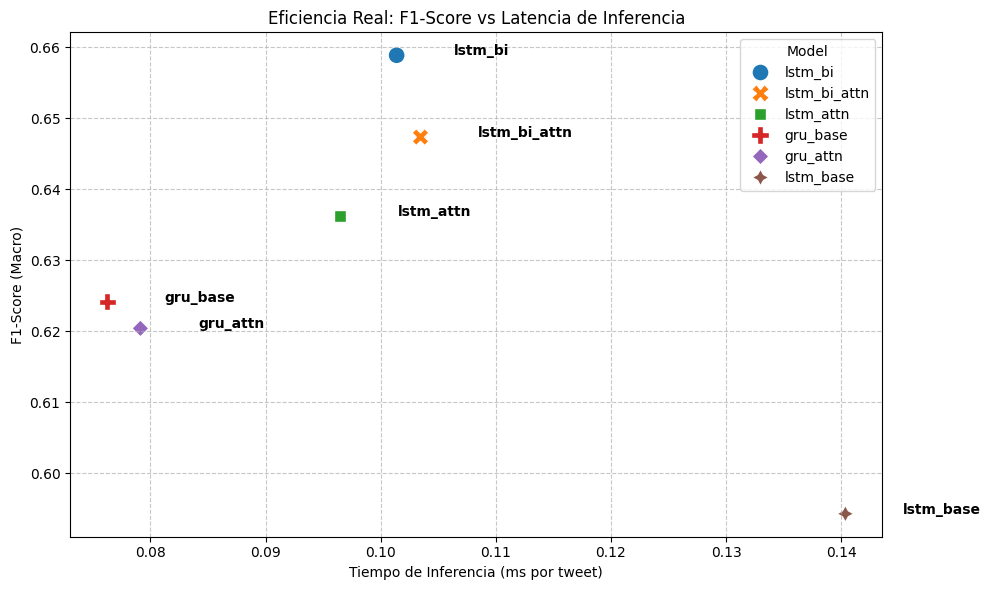

In [13]:
# =============================================================================
# 6. ANÁLISIS DE EFICIENCIA (Scatter Plot Final)
# =============================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Inference (ms/tweet)', y='F1 (Macro)', data=df_results, s=150, hue=df_results.index, style=df_results.index)

for line in range(0, df_results.shape[0]):
     plt.text(df_results['Inference (ms/tweet)'].iloc[line]+0.005, 
              df_results['F1 (Macro)'].iloc[line], 
              df_results.index[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Eficiencia Real: F1-Score vs Latencia de Inferencia')
plt.xlabel('Tiempo de Inferencia (ms por tweet)')
plt.ylabel('F1-Score (Macro)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Conclusiones del Experimento 1

1.  **Mejor Modelo Global**: Observar el Leaderboard. Generalmente, los modelos bidireccionales con atención (`lstm_bi_attn`) obtienen mejores métricas, pero a un costo computacional mayor.
2.  **Trade-off de Velocidad**: El gráfico de dispersión muestra si la ganancia en F1 justifica el aumento en latencia. Para sistemas de trading de alta frecuencia (HFT), un modelo más simple (`gru_base`) podría ser preferible si la diferencia en F1 es marginal.
3.  **Errores Comunes**: Las matrices de confusión revelan si el modelo confunde más las clases "Neutral" con "Alcista/Bajista", lo cual es típico en datasets financieros ruidosos.